# Подготовка датасета

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

feature = 'Region'
size = 1000
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
df[feature] = df[feature].map({'West': -1, 'Midwest': -1, 'Northeast': 1, 'South': 1})
df = df.iloc[:, 1:].drop(columns=['City', 'State', 'County', 'Division', 'Longitude', 'Latitude'])
for column in df:
    if column != 'Region':
        mean = df[column].mean()
        std = df[column].std()
        outliers = np.where((df[column] - mean) / std >= 3)[0]
        df = df.drop(index=outliers).reset_index(drop=True)

west_df = resample(df.loc[df[feature] == -1], n_samples=size).reset_index(drop=True)
east_df = resample(df.loc[df[feature] == 1], n_samples=size).reset_index(drop=True)
df = pd.concat([west_df, east_df])
target = pd.Series(df[feature])
df = df.drop(columns=[feature])
df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)

# Зависимость высоты библиотечной реализации

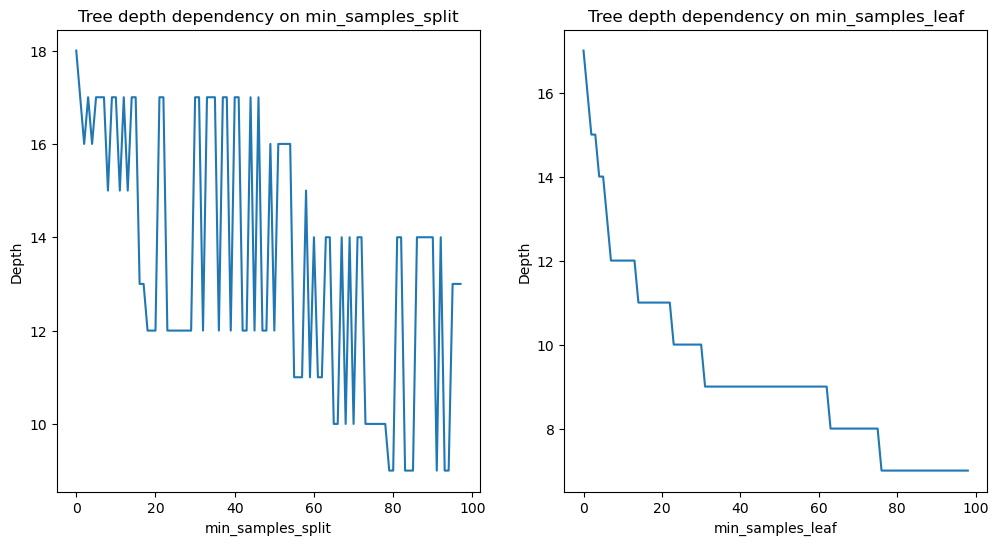

In [8]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

depths1 = []
for i in range(2, 100):
    classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=i)
    classifier.fit(X_train, y_train)
    depths1.append(classifier.get_depth())

depths2 = []
for i in range(1, 100):
    classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf=i)
    classifier.fit(X_train, y_train)
    depths2.append(classifier.get_depth())
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Tree depth dependency on min_samples_split')
ax[0].set_xlabel('min_samples_split')
ax[0].set_ylabel('Depth')
ax[0].plot(depths1)
ax[1].set_title('Tree depth dependency on min_samples_leaf')
ax[1].set_xlabel('min_samples_leaf')
ax[1].set_ylabel('Depth')
ax[1].plot(depths2)

# Подбор лучших гиперпараметров дерева решений

In [2]:
import optuna
from sklearn.metrics import f1_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train.iloc[: train_size]
valid_data = X_train.iloc[train_size:]
train_target = y_train.iloc[: train_size]
valid_target = y_train.iloc[train_size :]

## Для собственной реализации

In [3]:
from tree import DTreeClassifier

def my_objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 2, 100)
    max_leaf_size = trial.suggest_int('max_leaf_size', 2, 100)
    classifier = DTreeClassifier(criterion, max_depth, max_leaf_size)
    classifier.fit(train_data, feature)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-04-29 19:26:11,127] A new study created in memory with name: no-name-79ecc11c-ec86-4e09-8485-06ef78bb352c
[I 2024-04-29 19:26:19,184] Trial 0 finished with value: 0.6991869918699187 and parameters: {'criterion': 'gini', 'max_depth': 56, 'max_leaf_size': 53}. Best is trial 0 with value: 0.6991869918699187.
[I 2024-04-29 19:26:24,813] Trial 1 finished with value: 0.714859437751004 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'max_leaf_size': 39}. Best is trial 1 with value: 0.714859437751004.
[I 2024-04-29 19:26:32,739] Trial 2 finished with value: 0.6206896551724138 and parameters: {'criterion': 'gini', 'max_depth': 72, 'max_leaf_size': 73}. Best is trial 1 with value: 0.714859437751004.
[I 2024-04-29 19:26:35,206] Trial 3 finished with value: 0.7096774193548387 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_leaf_size': 86}. Best is trial 1 with value: 0.714859437751004.
[I 2024-04-29 19:26:42,646] Trial 4 finished with value: 0.7096774193548387 and p

{'criterion': 'gini', 'max_depth': 67, 'max_leaf_size': 4}


## Для библиотечной реализации

In [4]:
from sklearn.tree import DecisionTreeClassifier

def sklearn_objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    classifier = DecisionTreeClassifier(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split
    )
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-04-29 22:03:57,835] A new study created in memory with name: no-name-17919bcd-f853-47ed-8f0c-2fbf3158fff6
[I 2024-04-29 22:03:57,873] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 93, 'min_samples_split': 37}. Best is trial 0 with value: 1.0.
[I 2024-04-29 22:03:57,883] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 27, 'min_samples_split': 42}. Best is trial 0 with value: 1.0.
[I 2024-04-29 22:03:57,901] Trial 2 finished with value: 1.0 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 53, 'min_samples_split': 56}. Best is trial 0 with value: 1.0.
[I 2024-04-29 22:03:57,913] Trial 3 finished with value: 1.0 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 8}. Best is trial 0 with value: 1.0.
[I 2024-04-29 22:03:57,922] Trial 4 finished with value: 1.0 and parameters: {'criterion': 'log_lo

{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 93, 'min_samples_split': 37}


# Зависимость качества от высоты дерева

In [ ]:
from tree import DTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

my_train_scores = []
my_test_scores = []
for i in range(1, 100):
    classifier = DTreeClassifier(criterion='entropy', max_depth=i, max_leaf_size=4)
    classifier.fit(X_train, feature)
    my_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    my_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

sklearn_train_scores = []
sklearn_test_scores = []
for i in range(1, 100):
    classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=37)
    classifier.fit(X_train, y_train)
    sklearn_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    sklearn_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

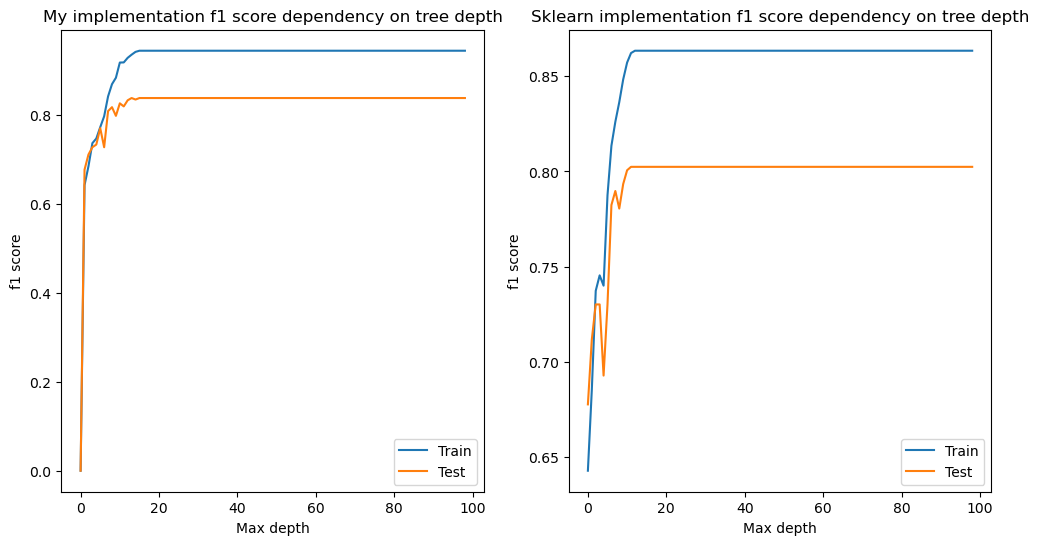

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('My implementation f1 score dependency on tree depth')
ax[0].set_xlabel('Max depth')
ax[0].set_ylabel('f1 score')
ax[0].plot(my_train_scores, label='Train')
ax[0].plot(my_test_scores, label='Test')
ax[0].legend()
ax[1].set_title('Sklearn implementation f1 score dependency on tree depth')
ax[1].set_xlabel('Max depth')
ax[1].set_ylabel('f1 score')
ax[1].plot(sklearn_train_scores, label='Train')
ax[1].plot(sklearn_test_scores, label='Test')
ax[1].legend()

# Подбор лучших гиперпараметров случайного леса

## Для собственной реализации

In [10]:
from tree import RForestClassifier
from sklearn.metrics import f1_score

def my_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 1, 50)
    max_leaf_size = trial.suggest_int('max_leaf_size', 2, 50)
    classifier = RForestClassifier(n_estimators, criterion, max_depth, max_leaf_size)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-05-01 16:11:43,960] A new study created in memory with name: no-name-f4ca5e04-1902-4032-9aed-6f0ebcb9b3c8
[I 2024-05-01 16:11:47,271] Trial 0 finished with value: 0.6869806094182825 and parameters: {'n_estimators': 69, 'criterion': 'gini', 'max_depth': 30, 'max_leaf_size': 5}. Best is trial 0 with value: 0.6869806094182825.
[I 2024-05-01 16:11:48,116] Trial 1 finished with value: 0.6538461538461539 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 40, 'max_leaf_size': 27}. Best is trial 0 with value: 0.6869806094182825.
[I 2024-05-01 16:11:49,072] Trial 2 finished with value: 0.6857142857142857 and parameters: {'n_estimators': 14, 'criterion': 'entropy', 'max_depth': 19, 'max_leaf_size': 26}. Best is trial 0 with value: 0.6869806094182825.
[I 2024-05-01 16:11:49,936] Trial 3 finished with value: 0.6736111111111112 and parameters: {'n_estimators': 31, 'criterion': 'gini', 'max_depth': 4, 'max_leaf_size': 18}. Best is trial 0 with value: 0.6869806094182825

{'n_estimators': 38, 'criterion': 'entropy', 'max_depth': 33, 'max_leaf_size': 4}


## Для библиотечной реализации

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def sklearn_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    classifier = RandomForestClassifier(
        n_estimators=n_estimators, 
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split
    )
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-05-01 14:47:31,325] A new study created in memory with name: no-name-9eadd5ab-4088-4500-98b2-dba81a2badad
[I 2024-05-01 14:47:31,762] Trial 0 finished with value: 0.7717041800643086 and parameters: {'n_estimators': 47, 'criterion': 'log_loss', 'max_depth': 89, 'min_samples_split': 54}. Best is trial 0 with value: 0.7717041800643086.
[I 2024-05-01 14:47:31,940] Trial 1 finished with value: 0.775 and parameters: {'n_estimators': 10, 'criterion': 'log_loss', 'max_depth': 42, 'min_samples_split': 15}. Best is trial 1 with value: 0.775.
[I 2024-05-01 14:47:32,844] Trial 2 finished with value: 0.7610062893081762 and parameters: {'n_estimators': 79, 'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 97}. Best is trial 1 with value: 0.775.
[I 2024-05-01 14:47:33,572] Trial 3 finished with value: 0.8136645962732919 and parameters: {'n_estimators': 61, 'criterion': 'gini', 'max_depth': 46, 'min_samples_split': 9}. Best is trial 3 with value: 0.8136645962732919.
[I 2024-05-01 14:4

{'n_estimators': 93, 'criterion': 'gini', 'max_depth': 36, 'min_samples_split': 4}


# Зависимость качества от числа деревьев случайного леса

In [13]:
from tree import RForestClassifier
from sklearn.metrics import f1_score

my_train_scores = []
my_test_scores = []
for i in range(1, 100):
    classifier = RForestClassifier(n_estimators=i, criterion='entropy', max_depth=33, max_leaf_size=4)
    classifier.fit(X_train, y_train)
    my_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    my_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

sklearn_train_scores = []
sklearn_test_scores = []
for i in range(1, 100):
    classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=36, min_samples_split=4)
    classifier.fit(X_train, y_train)
    sklearn_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    sklearn_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

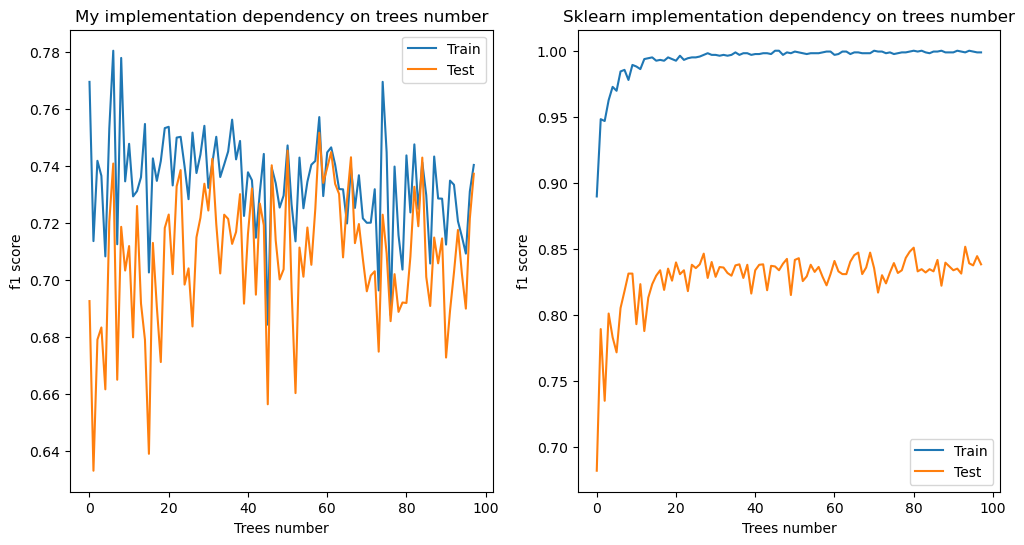

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('My implementation dependency on trees number')
ax[0].set_xlabel('Trees number')
ax[0].set_ylabel('f1 score')
ax[0].plot(my_train_scores, label='Train')
ax[0].plot(my_test_scores, label='Test')
ax[0].legend()
ax[1].set_title('Sklearn implementation dependency on trees number')
ax[1].set_xlabel('Trees number')
ax[1].set_ylabel('f1 score')
ax[1].plot(sklearn_train_scores, label='Train')
ax[1].plot(sklearn_test_scores, label='Test')
ax[1].legend()

# Подбор лучших гиперпараметров бустинга

## Для собственной реализации

In [12]:
from tree import BoostingClassifier
from sklearn.metrics import f1_score

def my_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 1, 5)
    max_leaf_size = trial.suggest_int('max_leaf_size', 50, 100)
    classifier = BoostingClassifier(n_estimators, criterion, max_depth, max_leaf_size)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-05-01 22:56:36,596] A new study created in memory with name: no-name-e0b4ad80-2a8c-4c9d-a28e-7acb4e93f2f3
[I 2024-05-01 22:58:29,662] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_size': 89}. Best is trial 0 with value: 0.0.
[I 2024-05-01 22:58:39,520] Trial 1 finished with value: 0.4041994750656168 and parameters: {'n_estimators': 14, 'criterion': 'entropy', 'max_depth': 2, 'max_leaf_size': 71}. Best is trial 1 with value: 0.4041994750656168.
[I 2024-05-01 22:59:27,886] Trial 2 finished with value: 0.5734939759036145 and parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 5, 'max_leaf_size': 54}. Best is trial 2 with value: 0.5734939759036145.
[I 2024-05-01 22:59:30,422] Trial 3 finished with value: 0.6526315789473685 and parameters: {'n_estimators': 30, 'criterion': 'entropy', 'max_depth': 1, 'max_leaf_size': 61}. Best is trial 3 with value: 0.6526315789473685.
[I 2024-05-01 22:59:30,936]

{'n_estimators': 48, 'criterion': 'gini', 'max_depth': 5, 'max_leaf_size': 55}


## Для библиотечной реализации

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

def sklearn_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    classifier = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        loss=loss,
        criterion=criterion,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_samples_split=min_samples_split
    )
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-05-01 21:02:57,016] A new study created in memory with name: no-name-60248ea7-70ff-45e9-b4e6-5fc4c0460aa8
[I 2024-05-01 21:02:58,939] Trial 0 finished with value: 0.7831715210355987 and parameters: {'n_estimators': 86, 'loss': 'log_loss', 'criterion': 'squared_error', 'learning_rate': 0.007129701584523112, 'max_depth': 29, 'min_samples_split': 66}. Best is trial 0 with value: 0.7831715210355987.
[I 2024-05-01 21:03:00,207] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 42, 'loss': 'log_loss', 'criterion': 'squared_error', 'learning_rate': 0.00018297176872647246, 'max_depth': 29, 'min_samples_split': 9}. Best is trial 0 with value: 0.7831715210355987.
[I 2024-05-01 21:03:01,322] Trial 2 finished with value: 0.7647058823529411 and parameters: {'n_estimators': 66, 'loss': 'exponential', 'criterion': 'friedman_mse', 'learning_rate': 0.004176703740430215, 'max_depth': 73, 'min_samples_split': 81}. Best is trial 0 with value: 0.7831715210355987.
[I 2024-05-01 21:03

{'n_estimators': 89, 'loss': 'log_loss', 'criterion': 'friedman_mse', 'learning_rate': 0.05697103687844309, 'max_depth': 44, 'min_samples_split': 45}


# Зависимость качества от числа деревьев бустинга

In [13]:
from tree import BoostingClassifier
from sklearn.metrics import f1_score

my_train_scores = []
my_test_scores = []
for i in range(1, 50):
    classifier = BoostingClassifier(n_estimators=i, criterion='gini', max_depth=5, max_leaf_size=55)
    classifier.fit(X_train, y_train)
    my_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    my_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

sklearn_train_scores = []
sklearn_test_scores = []
for i in range(1, 50):
    classifier = GradientBoostingClassifier(
        n_estimators=i, 
        loss='log_loss',
        criterion='friedman_mse', 
        learning_rate=0.057,
        max_depth=44, 
        min_samples_split=45
    )
    classifier.fit(X_train, y_train)
    sklearn_train_scores.append(f1_score(y_train, classifier.predict(X_train)))
    sklearn_test_scores.append(f1_score(y_test, classifier.predict(X_test)))

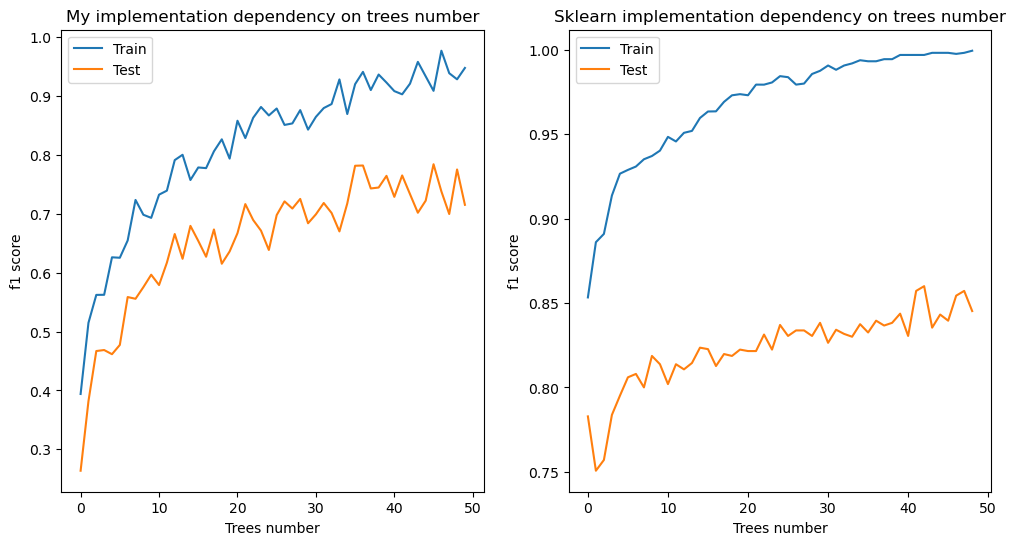

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('My implementation dependency on trees number')
ax[0].set_xlabel('Trees number')
ax[0].set_ylabel('f1 score')
ax[0].plot(my_train_scores, label='Train')
ax[0].plot(my_test_scores, label='Test')
ax[0].legend()
ax[1].set_title('Sklearn implementation dependency on trees number')
ax[1].set_xlabel('Trees number')
ax[1].set_ylabel('f1 score')
ax[1].plot(sklearn_train_scores, label='Train')
ax[1].plot(sklearn_test_scores, label='Test')
ax[1].legend()